The most recent version of  ATL03  is  005
Simplified polygon coordinates based on shapefile input: -157.66158921298853,21.303332316908676,-157.71931491676324,21.502594137149547,-157.91751621280537,21.648876773333157,-157.8098973748858,21.411269199862037,-157.66158921298853,21.303332316908676


/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code/atl_module/ATL03_download.py:139: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = gdf.buffer(50)  # create buffer for plot bounds


There are 69 granules of ATL03 version 005 over my area and time of interest.
The average size of each granule is 862.48 MB and the total size of all 69 granules is 59511.36 MB
These reformatting options are available: ['TABULAR_ASCII', 'NetCDF4-CF', 'NetCDF-3']
No reprojection options are supported with your requested format
There will be 1 total order(s) processed for our ATL03 request.
https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL03&version=005&polygon=-157.66158921298853,21.303332316908676,-157.71931491676324,21.502594137149547,-157.91751621280537,21.648876773333157,-157.8098973748858,21.411269199862037,-157.66158921298853,21.303332316908676&Boundingshape={"type":"FeatureCollection","features":[{"id":"0","type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-157.66158921298853,21.303332316908676],[-157.71931491676324,21.502594137149547],[-157.91751621280537,21.648876773333157],[-157.8098973748858,21.411269199862037],[-157.66158921298853,21.30333

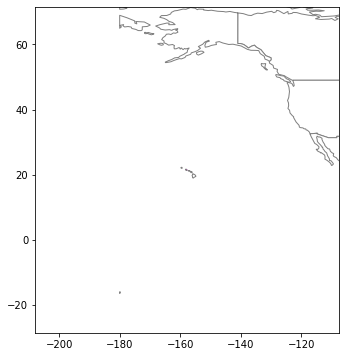

In [15]:
from atl_module.ATL03_download import request_segments_only, request_full_data_shapefile
from netCDF4 import Dataset
import xarray as xr
from atl_module.load_netcdf import get_beams
import pandas as pd
from atl_module import ocean_color
from glob import glob
import geopandas as gpd

# request_segments_only('../data/global_analysis/new_layer.shp','../data/test_sites/mililani/test_granules')
request_full_data_shapefile(
    "../data/global_analysis/new_layer.shp", "../data/test_sites/mililani"
)

In [2]:
beamlist = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]

xrlist = []


for file_ in glob("../data/test_sites/mililani/test_granules/ATL03/*.nc"):
    for beam in beamlist:
        try:
            ds = xr.open_dataset(file_, group=f"/{beam}/geolocation")
            ds = ds.assign(beamtype=beam)
            xrlist.append(ds)
        except OSError:
            continue

combo_array = xr.concat(xrlist, dim="delta_time")

combo_array = combo_array.set_coords(["reference_photon_lat", "reference_photon_lon"])
combo_array = combo_array.rename({"dimension5": "ds_surf_type"})

In [6]:
# only get ocean segments
combo_array = combo_array.sel(
    ds_surf_type=1
    # skip where there are nophotons
).where(combo_array.segment_ph_cnt > 1, drop=True)

# remove segemnts not assosciated with the ocean
combo_array = combo_array.where(combo_array.surf_type == 1, drop=True)
combo_array = combo_array.rename(
    {"reference_photon_lat": "lat", "reference_photon_lon": "lon", "delta_time": "time"}
)

KeyError: 'ds_surf_type is not a valid dimension or coordinate'

In [7]:
combo_array

<xarray.Dataset>
Dimensions:         (time: 14946)
Coordinates:
  * time            (time) datetime64[ns] 2018-10-16T14:02:31.364691256 ... 2...
    lat             (time) float64 21.52 21.32 21.32 21.32 ... 21.61 21.61 21.61
    lon             (time) float64 -157.8 -157.7 -157.7 ... -157.9 -157.9 -157.9
Data variables:
    segment_ph_cnt  (time) float64 12.0 1.014e+03 1.056e+03 ... 11.0 12.0 12.0
    surf_type       (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    beamtype        (time) object 'gt2r' 'gt1l' 'gt1l' ... 'gt3r' 'gt3r' 'gt3r'
Attributes:
    Description:  Contains parameters related to geolocation.  The rate of al...
    data_rate:    Data within this group are stored at the ICESat-2 20m segme...

In [8]:
df = combo_array.to_dataframe().reset_index()
newdf = df.assign(date=df.time.dt.date).drop(columns="time").round({"lat": 1, "lon": 1})

uniquedf = pd.DataFrame(
    newdf.loc[:, ["lat", "lon", "date", "beamtype"]].value_counts()
).reset_index()
print(len(uniquedf), " Unique values")
sampledf = uniquedf

147  Unique values


In [9]:
a, b = ocean_color.get_zsd_info(
    sampledf.lat.values, sampledf.lon.values, sampledf.date.values
)
finaldf = sampledf.assign(zsd=a, sigma_zsd=b).drop(columns=0).astype({"date": "string"})

In [10]:
gpd.GeoDataFrame(
    finaldf,
    geometry=gpd.points_from_xy(
        finaldf.lon,
        finaldf.lat,
    ),
    crs="EPSG:4326",
).to_file("../data/test_sites/mililani/color_points.gpkg")

In [11]:
xrarray_final = (
    sampledf.assign(zsd=a, sigma_zsd=b)
    .drop(columns=0)
    .set_index(["date"])
    .to_xarray()
    .set_coords(["lat", "lon"])
)

In [12]:
dategroupby = finaldf.groupby(["date", "beamtype"]).mean()
gdf = gpd.GeoDataFrame(
    dategroupby,
    geometry=gpd.points_from_xy(
        dategroupby.lon,
        dategroupby.lat,
    ),
    crs="EPSG:4326",
)
gdf

lat    lon        zsd  sigma_zsd  \
date       beamtype                                       
2018-10-16 gt2r      21.50 -157.8  36.391811  15.980000   
2018-11-07 gt1l      21.35 -157.7  15.512530  62.489998   
           gt1r      21.35 -157.7  15.512530  62.489998   
2018-11-14 gt2l      21.50 -157.7  25.147228  58.590000   
           gt2r      21.50 -157.7  25.147228  58.590000   
...                    ...    ...        ...        ...   
2022-01-09 gt3r      21.55 -157.8  23.090351  54.004997   
2022-04-02 gt2l      21.60 -157.9  24.763449  45.270000   
           gt2r      21.60 -157.9  24.763449  45.270000   
           gt3l      21.60 -157.9  24.763449  45.270000   
           gt3r      21.60 -157.9  24.763449  45.270000   

                                        geometry  
date       beamtype                               
2018-10-16 gt2r      POINT (-157.80000 21.50000)  
2018-11-07 gt1l      POINT (-157.70000 21.35000)  
           gt1r      POINT (-157.70000 21.35000)  
2018-11-14 gt2l      POINT (-157.70000 21.50000)  
           gt2r      POINT (-157.70000 21.50000)  
...                                          ...  
2022-01-09 gt3r      POINT (-157.80000 21.55000)  
2022-04-02 gt2l      POINT (-157.90000 21.60000)  
           gt2r      POINT (-157.90000 21.60000)  
           gt3l      POINT (-157.90000 21.60000)  
           gt3r      POINT (-157.90000 21.60000)  

[107 rows x 5 columns]

In [13]:
gdf.to_file("../data/test_sites/mililani/color_points_mean.gpkg")